# Generate set of administrative regions to use in exposure grid
- The idea here is to get a globally comprehensive set of administrative boundaries at the `adm1` level or higher if the `adm1` level is not available
- Use `adm1` if available and `adm0` if not

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import warnings

import geopandas as gpd
import pandas as pd
from shapely.errors import ShapelyDeprecationWarning
from sliiders import settings as sset
from sliiders import spatial
from sliiders.io import read_shapefile, save_geoparquet, save_shapefile

## Read full `adm0` and `adm1` sets

In [5]:
adm0 = gpd.read_parquet(sset.PATH_GADM_ADM0_INT)
adm1 = gpd.read_parquet(sset.PATH_GADM_ADM1_INT)

# Filter out excluded ISOs
excluded_isos = sset.EXCLUDED_ISOS
adm0 = adm0.drop(excluded_isos, errors="ignore")
adm1 = adm1[~adm1["GID_0"].isin(excluded_isos)]

#### Select only countries in `adm0` that do not appear in the `adm1` set, to be included as intermediate `adm1` regions

In [6]:
adm0_as_adm1 = adm0.drop(adm1.GID_0.unique())

#### Concatenate all `adm1` regions

In [7]:
# load ocean shapefile
ocean_and_caspian = read_shapefile(sset.PATH_NATEARTH_OCEAN)
ocean_and_caspian = ocean_and_caspian.explode(index_parts=False)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message=".*Geometry is in a geographic CRS.*")
    ocean_and_caspian["area"] = ocean_and_caspian.area

# Sort so that ocean is first, Caspian is second
ocean_and_caspian = ocean_and_caspian.sort_values("area", ascending=False)
ocean_shape = ocean_and_caspian.geometry.values[0]

In [6]:
# save no-caspian file
save_geoparquet(
    gpd.GeoDataFrame({"geometry": [ocean_shape]}, geometry="geometry"),
    sset.PATH_NATEARTH_OCEAN_NOCASPIAN,
)

/home/jovyan/git-repos/sliiders/sliiders/io.py:67: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  obj.to_parquet(_path, **kwargs)


In [8]:
full = pd.concat((adm0_as_adm1.geometry, adm1.geometry)).to_frame("geometry")

full["ISO"] = full.index.str.split(".").str[0]
full.index.name = "adm1"
assert full.index.is_unique
seg_centroids = gpd.read_parquet(sset.PATH_SEG_CENTROIDS, columns=["geometry"]).geometry
coastlines = gpd.read_parquet(sset.PATH_GEOG_COASTLINES, columns=["geometry"]).geometry

In [61]:
with warnings.catch_warnings():
    try:
        warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
        out, adm0, coastal_segs = spatial.create_overlay_voronois(
            full, seg_centroids, coastlines, ocean_shape, "seg_adm", plot=True
        )
    except Exception as e:
        test = e
        raise

Generating global Voronoi shapes for regions...
...Subdividing region grid to ease computation


  0%|          | 0/363 [00:00<?, ?it/s]

...Creating Voronoi generator points
...Creating Voronoi diagram from generator points


  0%|          | 0/1779 [00:00<?, ?it/s]

...Revmoving already attributed land from voronoi


  0%|          | 0/1779 [00:00<?, ?it/s]

...stitching Voronoi with already attributed land
...cleaning Voronois


/srv/conda/envs/notebook/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/srv/conda/envs/notebook/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


  0%|          | 0/8 [00:00<?, ?it/s]

Assigning countries to segment centroids...


<Axes: >

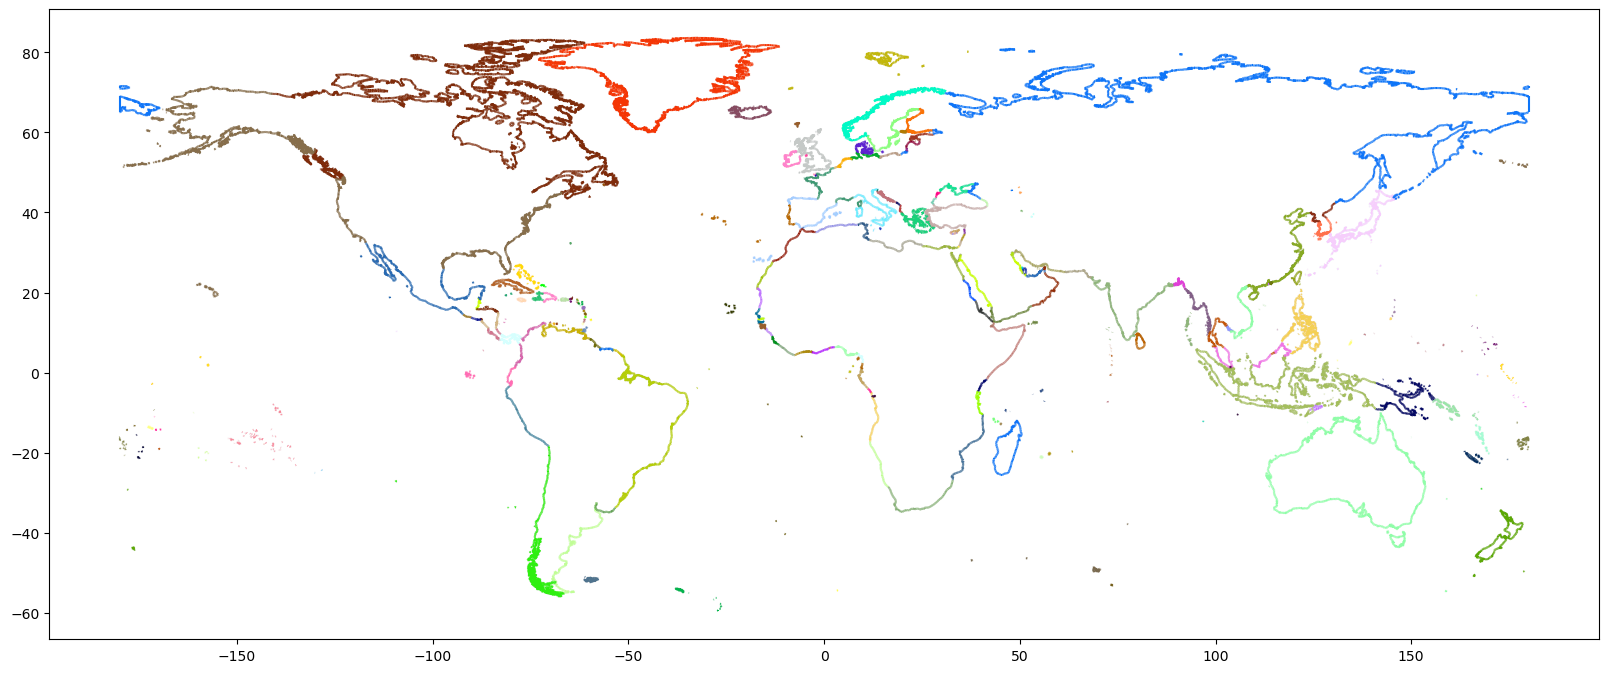

In [36]:
out.reset_index(drop=False).plot(
    color=spatial.add_rand_color(out.reset_index(drop=False), col="ISO"), figsize=(20, 20)
)

In [15]:
save_geoparquet(out, sset.PATH_SEG_REGION_VORONOI_INTERSECTIONS)
save_geoparquet(out.dissolve("station_id")[["geometry"]], sset.PATH_SEG_VORONOI)
save_geoparquet(coastal_segs, sset.PATH_SEGS)
save_geoparquet(adm0, sset.PATH_GADM_ADM0_VORONOI)
save_shapefile(out, sset.PATH_SEG_REGION_VORONOI_INTERSECTIONS_SHP)

/home/jovyan/git-repos/sliiders/sliiders/io.py:74: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  obj.to_parquet(_path, **kwargs)
/home/jovyan/git-repos/sliiders/sliiders/io.py:74: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in 